### Get data

In [1]:
# check the datasets
from helper_functions.unzip_file import unzip_file

# file_path = 'datas/playground-series-s4e4.zip'
# output_dir = 'datas/abalone-dataset'
# unzip_file(file_path, output_dir)

In [2]:
# read the data to dataframe
import pandas as pd
df_train = pd.read_csv('datas/abalone-dataset/train.csv')
df_test = pd.read_csv('datas/abalone-dataset/test.csv')
sample_sub = pd.read_csv('datas/abalone-dataset/sample_submission.csv')
# df_train.head(), df_test.head(), sample_sub.head()

数据信息：

1. 性别（Sex）：鲍鱼的性别，可能的取值为“M”（雄性）、“F”（雌性）和“I”（幼年）。
2. 长度（Length）：鲍鱼的最长尺寸，单位为毫米。
3. 直径（Diameter）：鲍鱼的最大直径，单位为毫米。
4. 高度（Height）：鲍鱼的高度，单位为毫米。
5. 整体重量（Whole weight）：整个鲍鱼的重量，单位为克。
6. 剔除壳后重量（Shucked weight）：去除壳后的鲍鱼重量，单位为克。
7. 肉重（Viscera weight）：鲍鱼肉的重量，单位为克。
8. 壳重（Shell weight）：鲍鱼壳的重量，单位为克。
9. 年龄（Rings）：鲍鱼的年龄，通过年轮的数量来确定。

In [3]:
from helper_functions.info_df import info_df
info_df(df_train)

Number of rows: 90615
Number of columns: 10

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB
None

DataFrame description:
                 id        Length      Diameter        Height  Whole weight  \
count  90615.000000  90615.000000  90615.000000  90615.000000  90615.000000   
mean   45307.000000      0.517098      0.

In [4]:
from helper_functions.plot_df import plot_numerics, plot_cat, plot_corr_matrix
df_train["Whole weight Ratio"]=df_train["Whole weight.1"]/df_train["Whole weight"]
cat_cols=['Sex']
num_cols=['Length', 'Diameter', 'Height', 
             'Whole weight','Whole weight.1', 
             'Whole weight.2', 'Shell weight', "Whole weight Ratio"]

In [5]:
df_test["Whole weight Ratio"]=df_test["Whole weight.1"]/df_test["Whole weight"]

In [6]:
df_test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Whole weight Ratio
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,0.499596
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,0.486775
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,0.419893
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,0.403318
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,0.439944


## Feature selections

In [7]:
import pandas as pd
import numpy as np
import matplotlib
from IPython.display import HTML
import base64  
from scipy.stats import skew
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Whole weight'}>,
        <Axes: title={'center': 'Whole weight.1'}>,
        <Axes: title={'center': 'Whole weight.2'}>],
       [<Axes: title={'center': 'Shell weight'}>,
        <Axes: title={'center': 'Whole weight Ratio'}>, <Axes: >]],
      dtype=object)

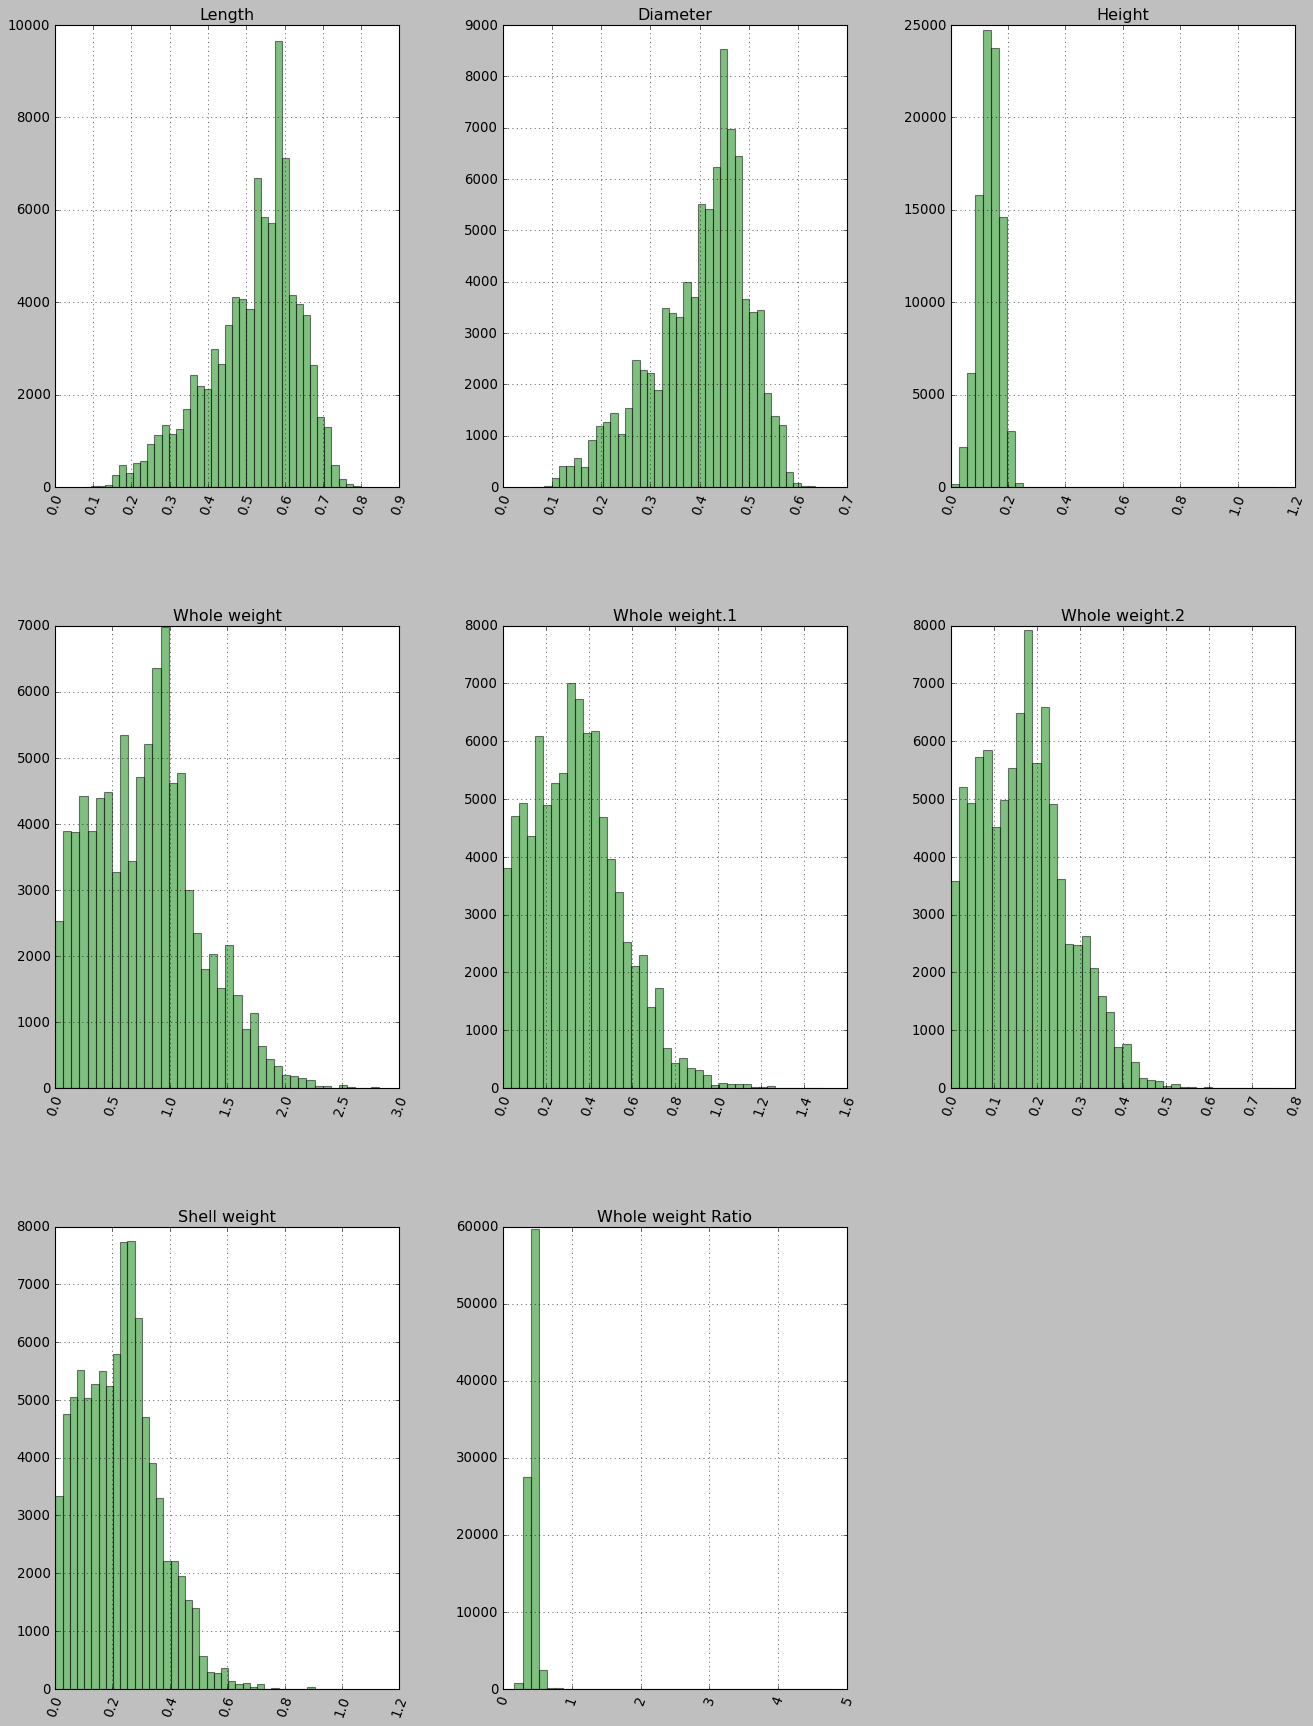

In [8]:
# plot histograms
%matplotlib inline
plt.style.use('classic')
df_train[num_cols].hist(figsize=(20, 26), bins=40, xrot=70, color = 'green',alpha=0.5)

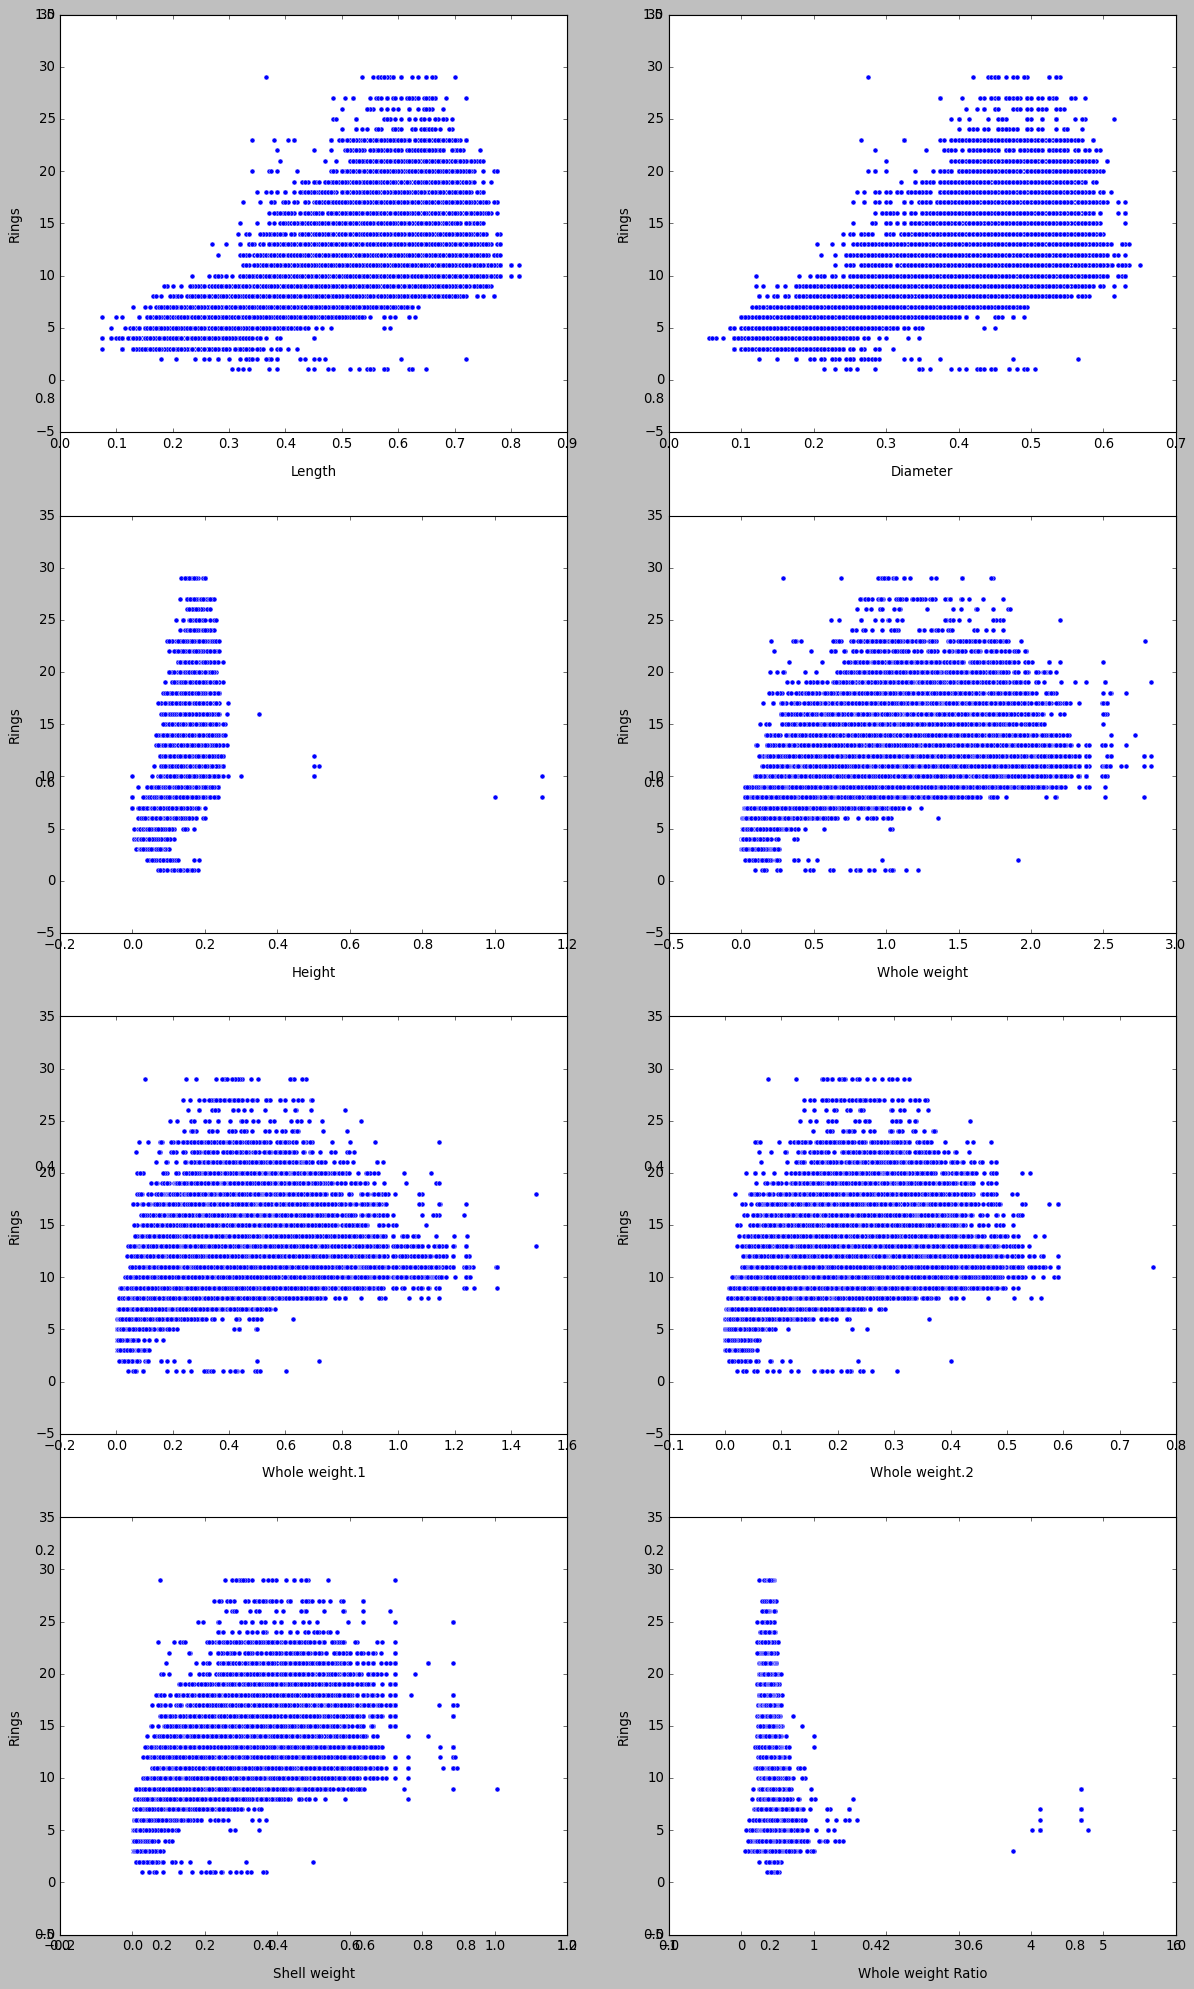

In [9]:
# Scatter Plots: find the relationship of 2-variables
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 30))
for i, feature in enumerate(list(df_train[num_cols]), 1):
    plt.subplot(4, 2, i)
    sns.scatterplot(x=feature, y='Rings', data=df_train)
    plt.xlabel('{}'.format(feature), size=12,labelpad=12.5)
    plt.ylabel('Rings', size=12, labelpad=12.5)
plt.show()

In [10]:
# Correlation Measure with Target
result = df_train.select_dtypes(include = ['int64', 'float64']).drop("Rings", axis=1).apply(lambda x: x.corr(df_train.Rings, "pearson"))
result = result.sort_values(kind="quicksort", ascending=False)
print(result)

Shell weight          0.694766
Height                0.665772
Diameter              0.636832
Length                0.623786
Whole weight          0.617274
Whole weight.2        0.588954
Whole weight.1        0.515067
id                    0.000938
Whole weight Ratio   -0.192626
dtype: float64


I will use Shell weight, Height, Whole weight, and Whole weight Ratio

In [11]:
# Categorical Variable Analysis
# Function responsible for plotting the BoxPlot
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

# Replacing the Missing Values in the Categorical Variables with the "MISSING" string
def fillMissingCatColumns(data,categorical):
    for c in categorical:
        data[c] = data[c].astype('category')
        if data[c].isnull().any():
            data[c] = data[c].cat.add_categories(['MISSING'])
            data[c] = data[c].fillna('MISSING')

# Main function responsible for plotting the BoxPlots
def getboxPlots(data, var, categorical):
    fillMissingCatColumns(data, categorical)
    f = pd.melt(data, id_vars=var, value_vars=categorical)
    g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
    g = g.map(boxplot, "value", var)

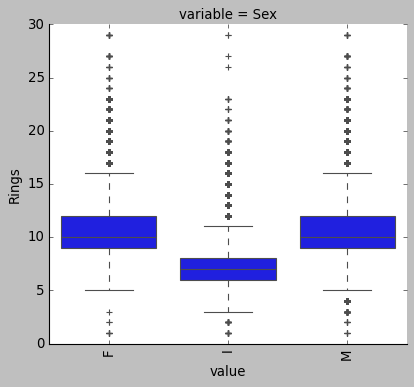

In [12]:
categorical = [f for f in df_train.columns if df_train.dtypes[f] == 'object']   
train_copy = df_train.copy(True) 
getboxPlots(train_copy, 'Rings', categorical)

In [13]:
df_train["Sex"].value_counts()

Sex
I    33093
M    31027
F    26495
Name: count, dtype: int64

I will of course take the Sex value

## Feature Transformation

In [14]:
df_train.shape, df_test.shape

((90615, 11), (60411, 10))

In [15]:
# combine all the data
features = ['Sex', 'Height', 'Whole weight', 'Shell weight', 'Whole weight Ratio']
train = df_train[features]
test = df_test[features]
all_data = pd.concat((train, test))

In [16]:
all_data.shape

(151026, 5)

In [17]:
all_data.head()

,Sex,Height,Whole weight,Shell weight,Whole weight Ratio
0,F,0.150,0.7715,0.2400,0.425794
1,F,0.145,1.1300,0.3200,0.405310
2,I,0.025,0.0210,0.0050,0.261905
3,M,0.150,0.9145,0.2500,0.410607
4,I,0.130,0.7820,0.1975,0.472506


In [18]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index # Getting the Numerical Features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) # Computing the Skewness of Columns

In [19]:
numeric_feats

Index(['Height', 'Whole weight', 'Shell weight', 'Whole weight Ratio'], dtype='object')

In [20]:
skewed_feats # 找出偏斜数据进行对数变换

Height                 0.309970
Whole weight           0.429309
Shell weight           0.479085
Whole weight Ratio    24.928148
dtype: float64

In [21]:
all_data['Whole weight Ratio'] = np.log1p(all_data['Whole weight Ratio'])

In [22]:
all_data.head()

,Sex,Height,Whole weight,Shell weight,Whole weight Ratio
0,F,0.150,0.7715,0.2400,0.354729
1,F,0.145,1.1300,0.3200,0.340258
2,I,0.025,0.0210,0.0050,0.232622
3,M,0.150,0.9145,0.2500,0.344020
4,I,0.130,0.7820,0.1975,0.386966


In [23]:
# one hot encoder on sex column
all_data = pd.get_dummies(all_data) # It automatically transforms the Categorical Variables

In [24]:
all_data.head()

,Height,Whole weight,Shell weight,Whole weight Ratio,Sex_F,Sex_I,Sex_M
0,0.150,0.7715,0.2400,0.354729,True,False,False
1,0.145,1.1300,0.3200,0.340258,True,False,False
2,0.025,0.0210,0.0050,0.232622,False,True,False
3,0.150,0.9145,0.2500,0.344020,False,False,True
4,0.130,0.7820,0.1975,0.386966,False,True,False


In [25]:
# check missing data
all_data.isna().sum()

Height                0
Whole weight          0
Shell weight          0
Whole weight Ratio    0
Sex_F                 0
Sex_I                 0
Sex_M                 0
dtype: int64

## Modeling

In [26]:
# train test split
# creating matrices for sklearn
X_train = all_data[:train.shape[0]] # Retrieving the rows for train from the all_data
X_test = all_data[train.shape[0]:] # Retrieving the rows for test from the all_data
y_train = df_train.Rings # Retrieving the output variable "Rings" of the train dataset 

In [27]:
X_train.shape, X_test.shape

((90615, 7), (60411, 7))

### dummy regressor baseline

In [28]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [29]:
y_pred = dummy_reg.predict(X_train)

In [30]:
# Computing the Root Mean Squared Error 
from sklearn.metrics import mean_squared_error
from math import sqrt
dummy_rmse = sqrt(mean_squared_error(y_train, y_pred))
print(dummy_rmse)

3.1762034180944028


### Multiple Linear Regression

In [31]:
from sklearn import linear_model
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = linear_reg.predict(X_train)

In [33]:
# Computing the Root Mean Squared Error 
from sklearn.metrics import mean_squared_error
from math import sqrt
linear_rmse = sqrt(mean_squared_error(y_train, y_pred))
print(linear_rmse)

2.061113020012425


### Ridge Regression

In [34]:
from sklearn import linear_model
ridge_reg = linear_model.Ridge(alpha=0.5)
ridge_reg.fit(X_train, y_train)

Ridge(alpha=0.5)

In [35]:
y_pred = ridge_reg.predict(X_train)

In [36]:
# Computing the Root Mean Squared Error 
from sklearn.metrics import mean_squared_error
from math import sqrt
ridge_rmse = sqrt(mean_squared_error(y_train, y_pred))
print(ridge_rmse)

2.0611343769137176


### Lasso Regression

In [37]:
from sklearn import linear_model
lasso_reg = linear_model.Lasso(alpha=0.5,max_iter=10000)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.5, max_iter=10000)

In [38]:
y_pred = lasso_reg.predict(X_train)

In [39]:
# Computing the Root Mean Squared Error 
from sklearn.metrics import mean_squared_error
from math import sqrt
lasso_rmse = sqrt(mean_squared_error(y_train, y_pred))
print(lasso_rmse)

2.7190810097249463


### Elastic Net Regression

In [40]:
from sklearn import linear_model
elastic_net_reg = linear_model.ElasticNet(l1_ratio=0.5)
elastic_net_reg.fit(X_train, y_train)

ElasticNet()

In [41]:
y_pred = elastic_net_reg.predict(X_train)

In [42]:
# Computing the Root Mean Squared Error 
from sklearn.metrics import mean_squared_error
from math import sqrt
elastic_net_rmse = sqrt(mean_squared_error(y_train, y_pred))
print(elastic_net_rmse)

2.972526451220087


### Support Vector Regression

In [43]:
# from sklearn.svm import SVR
# svr_reg =  SVR(kernel="linear")
# svr_reg.fit(X_train, y_train)

In [44]:
# y_pred = svr_reg.predict(X_train)

In [45]:
# # Computing the Root Mean Squared Error 
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# svr_rmse = sqrt(mean_squared_error(y_train, y_pred))
# print(svr_rmse)

### Nearest Neighbours Regression

In [52]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg =  KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [53]:
y_pred = knn_reg.predict(X_train)

In [54]:
# Computing the Root Mean Squared Error 
from sklearn.metrics import mean_squared_error
from math import sqrt
svr_rmse = sqrt(mean_squared_error(y_train, y_pred))
print(svr_rmse)

1.6608140024375067


### Decision Tree Regression

In [55]:
from sklearn import tree
tree_reg =  tree.DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [56]:
y_pred = tree_reg.predict(X_train)

In [57]:
# Computing the Root Mean Squared Error 
from sklearn.metrics import mean_squared_error
from math import sqrt
tree_rmse = sqrt(mean_squared_error(y_train, y_pred))
print(tree_rmse)

0.20777677291397711


## Submission of Results to Kaggle

In [58]:
# the submission file provided by the Kaggle 
sample_submission = pd.read_csv('datas/abalone-dataset/sample_submission.csv')
sample_submission.head()

,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10


In [59]:
# Function to create the Download link to the Submissions
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [60]:
# Generating the Submission File Using KNN
sample_submission_knn = sample_submission.copy(True)  # Making a Deep Copy of the file
sample_submission_knn["Rings"] = knn_reg.predict(X_test)
create_download_link(sample_submission_knn, title="Download KNN Regression Submission", filename="sample_submission_knn.csv")

只有0.74看来还是要学习一下kaggle网友了。